In [1]:
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
config = {'Z': 26,
         'l': 2,
         'U_data': 'Fe_U.csv',
         'P_data': 'Fe_P.csv'}

class radial_schrodinger_wave:
    def __init__(self, config):
        self.Z = config['Z']
        self.l = config['l']
        self.U_data = pd.read_csv(config['U_data']).to_numpy()
        self.P_data = pd.read_csv(config['P_data']).to_numpy()
        
        self.U_data[:,0] *=  0.88534138*np.power(self.Z, -1/3)
        self.P_data[:,0] *= 0.88534138*np.power(self.Z, -1/3)
    
    def P_func_and_delta(self, E, is_plot):
        '''
        Params: 
            E: photon energy, in the units of Rydberg
        '''
        if E<0:
            r_start = self.U_data[0,0]; r_end = 100*self.U_data[-1,0]; r_delta = 0.001
            r_mesh = np.arange(r_start, r_end, r_delta)[::-1]
            sol = [[1,0]]
            
            for r in r_mesh:
                P, dPdr = sol[-1][0], sol[-1][1]
                P -= r_delta*dPdr
                dPdr -= r_delta*(-(self._V(r)+E-self.l*(self.l+1)/np.power(r,2))*P)                
                sol.append([P, dPdr])
                sol = self._semi_normalization(sol)
            
            P = np.array(sol)[1:len(sol), 0]

            def integrand(x):
                return np.power(np.interp(x, r_mesh[::-1], P[::-1]),2)
            
            self.r_mesh = r_mesh[::-1]
            self.P = -(P/np.sqrt(integrate.quad(integrand, r_start, r_end, limit=10000)[0]))[::-1]

            if is_plot:
                plt.plot(self.r_mesh, self.P, label = 'calculated', alpha=0.5)
                plt.plot(self.P_data[:,0], self.P_data[:,1], label = 'data book', linestyle='dashed')
                plt.legend()
                plt.xscale('log')
                plt.title('bound state radial wave function')
                
            return self.P
        
        if E>0:
            r_start = self.U_data[0,0]; r_end = 100*self.U_data[-1,0]; r_delta = 0.001
            r_mesh = np.arange(r_start, r_end, r_delta)
            
            if self.l == 0:
                sol = [[r_start, 1]]
            if self.l == 1:
                sol = [[np.power(r_start, 2), 2*r_start]]
            if self.l == 2:
                sol = [[np.power(r_start, 3), 3*np.power(r_start, 2)]]
            if self.l == 3:
                sol = [[np.power(r_start, 4), 4*np.power(r_start, 3)]]
            
            for r in r_mesh:
                P, dPdr = sol[-1][0], sol[-1][1]
                P += r_delta*dPdr
                dPdr += r_delta*(-(self._V(r)+E-self.l*(self.l+1)/np.power(r,2))*P)
                sol.append([P, dPdr])
                sol = self._semi_normalization(sol)
            
            P = np.array(sol)[0:(len(sol)-1), 0]
            norm_const = np.power(np.pi, -1/2)*np.power(E, -1/4)/np.max(np.abs(P[round(0.9*len(r_mesh)):len(r_mesh)]))
            
            self.r_mesh = r_mesh; self.P = norm_const*P
            self.delta_l = self._delta(r_mesh[round(0.9*len(r_mesh)):len(r_mesh)], P[round(0.9*len(r_mesh)):len(r_mesh)], E)
            
            if is_plot:
                plt.plot(self.r_mesh, self.P, label = 'calculated')
                plt.legend()
                #plt.xscale('log')
                plt.title('scattering state radial wave function')
            
            return self.P, self.delta_l
    
    def _V(self, r):
        return (2*self.Z/r)*np.interp(r, self.U_data[:,0], self.U_data[:,1], left=self.U_data[0,1], right=self.U_data[-1,1])
    
    def _x2r(self, x):
        mu = 0.88534138*np.power(self.Z, -1/3)
        return mu*x
    
    def _delta(self, x, y, E):
        y_normalized = y/np.max(np.abs(y))
        delta_list = np.arange(0, 2*np.pi, 0.1)
        RSS = []
        fit_value_hist = []
        for delta in delta_list:
            fit_value = [np.sin(np.sqrt(E)*x_j - self.l*np.pi/2 - np.power(E, -1/2)*np.log(2*np.sqrt(E)*x_j)+delta) for x_j in x]
            RSS.append(np.mean([np.power(y_normalized[j]-fit_value[j], 2) for j in range(len(x))]))
            fit_value_hist.append(fit_value)
            
        delta_list_fine = np.arange(delta_list[np.argmin(RSS)]-0.1*np.pi, delta_list[np.argmin(RSS)]+0.1*np.pi, 0.01)
        RSS_fine = []
        fit_value_hist_fine = []
        for delta in delta_list_fine:
            fit_value = [np.sin(np.sqrt(E)*x_j - self.l*np.pi/2 - np.power(E, -1/2)*np.log(2*np.sqrt(E)*x_j)+delta) for x_j in x]
            RSS_fine.append(np.mean([np.power(y_normalized[j]-fit_value[j], 2) for j in range(len(x))]))
            fit_value_hist_fine.append(fit_value)
        
        return delta_list_fine[np.argmin(RSS_fine)]
    
    def _semi_normalization(self, ar):
        maximum = np.max(np.abs(ar[-1]))
        if maximum > 1e3:
            return (np.array(ar)/maximum).tolist()
        else:
            return ar

array([-1.05066847e-003, -2.54385493e-003, -4.13265148e-003, ...,
       -2.80021603e-117, -2.80021213e-117, -2.80021018e-117])

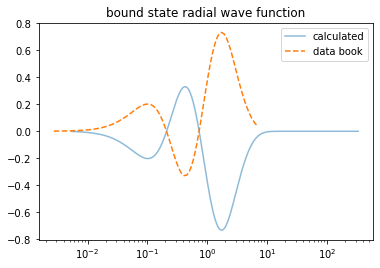

In [3]:
config = {'Z': 34,
         'l': 1,
         'U_data': 'Se_U.csv',
         'P_data': 'Se_P.csv'}

temp = radial_schrodinger_wave(config)
temp.P_func_and_delta(-.7015, True)

In [ ]:
config = {'Z': 34,
         'orbital': 'pz',
         'U_data': 'Se_U.csv',
         'P_data': 'Se_P.csv',
         'E_nl': -0.7015}

class matrix_element:
    def __init__(self, config):
        self.config = config
        self.Z = config['Z']
        self.orbital = config['orbital']
        self.U_data = pd.read_csv(config['U_data']).to_numpy()
        self.P_data = pd.read_csv(config['P_data']).to_numpy()
        self.E_nl = config['E_nl']
        
        if self.orbital[0] == 's':
            self.l = 0
        if self.orbital[0] == 'p':
            self.l = 1
        if self.orbital[0] == 'd':
            self.l = 2
        
        self.U_data[:,0] *=  0.88534138*np.power(self.Z, -1/3)
        self.P_data[:,0] *= 0.88534138*np.power(self.Z, -1/3)
        
        self.r_mesh_start = self.U_data[0,0]
        self.r_mesh_end = 100*self.U_data[-1,0]
        self.r_mesh_delta = 0.001
        
        self.prefactor = 4*np.pi*np.power(0.52918,2)/(3*13704)

    def matrix_element_core(self, hn, theta_epsilon=2*np.pi/9, phi_epsilon=np.pi/2, k_x=0.01, k_y=0.01):
        
        print('--- calculating matrix element at hn = ', hn, ' eV, k_x=', k_x, ', k_y=', k_y)
        theta_k, phi_k = self._momentum2angle(hn, k_x, k_y)
        epsilon_x = np.sin(theta_epsilon)*np.cos(phi_epsilon)
        epsilon_y = np.sin(theta_epsilon)*np.sin(phi_epsilon)
        epsilon_z = np.cos(theta_epsilon)
        #print('epsilon_x: ', epsilon_x, '; epsilon_y: ', epsilon_y, '; epsilon_z: ', epsilon_z)
        
        if self.l == 0:
            R_1, delta_1 = self._radial_int_and_delta(hn, self.l, self.l+1)
            k = 0.512*np.sqrt(hn + self.E_nl*13.605693)
            k_z = np.sqrt(k**2-k_x**2-k_y**2)
            return (self.prefactor*hn*4*np.pi*np.power(R_1, 2)*np.power(epsilon_x*k_x+epsilon_y*k_y+epsilon_z*k_z, 2), R_1, delta_1)
        
        if self.l == 1:
            R_0, delta_0 = self._radial_int_and_delta(hn, self.l, self.l-1)
            R_2, delta_2 = self._radial_int_and_delta(hn, self.l, self.l+1)

            if self.orbital == 'px':
                X_0 = 2*np.sqrt(2*np.pi)*R_0*np.sqrt(1/3)*epsilon_x
                X_2 = 2*np.sqrt(np.pi)*R_2*(-np.sqrt(3/4)*np.power(np.sin(theta_k), 2)*(epsilon_x*np.cos(2*phi_k)\
                      +epsilon_y*np.sin(2*phi_k))+epsilon_x*np.sqrt(1/12)*(3*np.power(np.cos(theta_k),2)-1)\
                      -epsilon_z*np.sqrt(3)*np.sin(theta_k)*np.cos(theta_k)*np.cos(phi_k))
                
            if self.orbital == 'py':
                X_0 = 2*np.sqrt(np.pi)*R_0*np.sqrt(1/3)*epsilon_y
                X_2 = 2*np.sqrt(np.pi)*R_2*(np.sqrt(3/4)*np.power(np.sin(theta_k),2)*(-epsilon_x*np.sin(2*phi_k)\
                        +epsilon_y*np.cos(2*phi_k))+epsilon_y*np.sqrt(1/12)*(3*np.power(np.cos(theta_k),2)-1)\
                        -epsilon_z*np.sqrt(3)*np.sin(theta_k)*np.cos(theta_k)*np.sin(phi_k))
            
            if self.orbital == 'pz':
                X_0 = 2*np.sqrt(2*np.pi)*R_0*np.sqrt(1/6)*epsilon_z
                X_2 = 2*np.sqrt(2*np.pi)*R_2*(np.sqrt(3/2)*np.sin(theta_k)*np.cos(theta_k)\
                        *(-epsilon_x*np.cos(phi_k)-epsilon_y*np.sin(phi_k))\
                        - epsilon_z*np.sqrt(1/6)*(3*np.power(np.cos(theta_k),2)-1))
            
            return (self.prefactor*hn*(np.power(X_0, 2) + np.power(X_2, 2) + 2*X_0*X_2*np.cos(delta_2-delta_0)), R_0, R_2,\
                    delta_0, delta_2)
        
        if self.l == 2:
            R_1, delta_1 = self._radial_int_and_delta(hn, self.l, self.l-1)
            R_3, delta_3 = self._radial_int_and_delta(hn, self.l, self.l+1)
            
            if self.orbital == 'dxy':
                X_1 = 2*np.sqrt(np.pi)*R_1*np.sqrt(3/5)*np.sin(theta_k)*(epsilon_x*np.sin(phi_k)+epsilon_y*np.cos(phi_k))
                X_3 = -2*np.sqrt(np.pi)*R_3*(-np.sqrt(3/80)*np.sin(phi_k)*(5*np.power(np.cos(theta_k),2)-1)*(epsilon_x*np.sin(phi_k)\
                        + epsilon_y*np.cos(phi_k))+np.sqrt(15/16)*np.power(np.sin(theta_k),3)*(epsilon_x*np.sin(3*phi_k)-epsilon_y*np.cos(3*phi_k))\
                        + epsilon_z*np.sqrt(15/4)*np.power(np.sin(theta_k),2)*np.cos(theta_k)*np.sin(2*phi_k))
                
            if self.orbital == 'dxz':
                X_1 = 2*np.sqrt(np.pi)*R_1*(np.sqrt(3/5)*(epsilon_x*np.cos(theta_k)+epsilon_z*np.sin(theta_k)*np.cos(phi_k)))
                X_3 = -2*np.sqrt(np.pi)*R_3*(np.sqrt(15/4)*np.power(np.sin(theta_k),2)*np.cos(theta_k)*(epsilon_x*np.cos(2*phi_k)\
                    + epsilon_y*np.sin(2*phi_k))-epsilon_x*np.sqrt(3/20)*(5*np.power(np.cos(theta_k),3)-3*np.cos(theta_k))\
                    + epsilon_z*np.sqrt(3/5)*np.sin(theta_k)*(5*np.power(np.cos(theta_k),2)-1)*np.cos(phi_k))
                
            if self.orbital == 'dyz':
                X_1 = 2*np.sqrt(np.pi)*R_1*(np.sqrt(3/5)*(epsilon_y*np.cos(theta_k)+epsilon_z*np.sin(theta_k)*np.sin(phi_k)))
                X_3 = -2*np.sqrt(np.pi)*R_3*(np.sqrt(15/4)*np.power(np.sin(theta_k),2)*np.cos(theta_k)*(epsilon_x*np.sin(2*phi_k)\
                    - epsilon_y*np.cos(2*phi_k))-epsilon_y*np.sqrt(3/20)*(5*np.power(np.cos(theta_k),3)-3*np.cos(theta_k))\
                    + epsilon_z*np.sqrt(3/5)*np.sin(theta_k)*(5*np.power(np.cos(theta_k),2)-1)*np.sin(phi_k))
                
            return (self.prefactor*hn*(np.power(X_1, 2) + np.power(X_3, 2) + 2*X_1*X_3*np.cos(delta_3-delta_1)), R_1, R_3,\
                    delta_1, delta_3)
    
    def matrix_element_hn_dependence(self, hn_start, hn_end, hn_delta, \
                                     theta_epsilon=2*np.pi/9, phi_epsilon=np.pi/2, k_x=0.01, k_y=0.01,\
                                    save_file = 'matrix_element.csv'):
        
        hn_range = np.arange(hn_start, hn_end, hn_delta)
        result_list = [self.matrix_element_core(hn, theta_epsilon, phi_epsilon, theta_k, phi_k) for hn in hn_range]
        matrix_element_list = [j[0] for j in result_list]
        R_0_list = [j[1] for j in result_list]; R_2_list = [j[2] for j in result_list]
        delta_0_list = [j[3] for j in result_list]; delta_2_list = [j[4] for j in result_list]
                
        plt.plot(hn_range, matrix_element_list)
        plt.yscale('log')
        plt.xlabel('photon energy (eV)')
        plt.ylabel('matrix element')
        plt.title(''.join(['matrix element for Z=', str(self.Z), ', l=', str(self.l)]))
        
        np.savetxt(save_file, np.array([hn_range.tolist(), matrix_element_list, R_0_list, R_2_list,\
                                                   delta_0_list, delta_2_list]).T, delimiter=',')
        
        return (hn_range, matrix_element_list, R_0_list, R_2_list, delta_0_list, delta_2_list)
    
    def total_cross_section_core(self, hn, N_nl):
        '''
        params:
            hn: photon energy, in units of eV
            N_nl: the number of electrons in the nl subshell (=2(2l+1) if filled)
            
        return:
            total cross section 
        '''
        print('--- calculating total cross section at hn = ', hn, ' eV ---')
        if self.l == 0:
            R_1, delta_1 = self._radial_int_and_delta(hn, self.l, self.l+1)
            return self.prefactor*(N_nl)*hn*(self.l+1)*np.power(R_1, 2)/(2*self.l+1)
        
        if self.l == 1:
            R_0, delta_0 = self._radial_int_and_delta(hn, self.l, self.l-1)
            R_2, delta_2 = self._radial_int_and_delta(hn, self.l, self.l+1)
            return self.prefactor*(N_nl)*hn*(self.l*np.power(R_0,2) + (self.l+1)*np.power(R_2, 2))/(2*self.l+1)
        
        if self.l == 2:
            R_1, delta_1 = self._radial_int_and_delta(hn, self.l, self.l-1)
            R_3, delta_3 = self._radial_int_and_delta(hn, self.l, self.l+1)
            return self.prefactor*(N_nl)*hn*(self.l*np.power(R_1,2) + (self.l+1)*np.power(R_3, 2))/(2*self.l+1)
        
    def total_cross_section_hn_dependence(self, hn_start, hn_end, hn_delta, N_nl, save_file = 'total_cross_section.csv'):
        '''
        params:
            hn_start, hn_end, hn_delta: defines the calculated photon energy range
            N_nl: the number of electrons in the nl subshell (=2(2l+1) if filled)
            
        return:
            a two-dimensional array, with first column the photon energy and second column the total cross section
        '''
        hn_range = np.arange(hn_start, hn_end, hn_delta)
        result = [self.total_cross_section_core(j, N_nl) for j in hn_range]
        
        plt.plot(hn_range, result)
        plt.title('total cross section')
        plt.yscale('log')
        
        np.savetxt(save_file, np.array([hn_range.tolist(), result]).T, delimiter=',')
        
        return np.array([hn_range.tolist(), result]).T
    
    def _radial_int_and_delta(self, hn, l_bound, l_free):
        '''
        calculate R_l(E_{kin}).
        params:
            hn: photon energy, in units of eV
            l_bound: angular momentum of bound state
            l_free: angular momentum of free state
            
        '''
        config = {'Z': self.Z,
                 'l': l_bound,
                 'U_data': self.config['U_data'],
                 'P_data': self.config['P_data']}
        radial_wave = radial_schrodinger_wave(config)
        R_1 = radial_wave.P_func_and_delta(self.E_nl, False)
        #plt.plot(radial_wave.r_mesh, R_1, label = 'R_1')

        config = {'Z': self.Z,
                 'l': l_free,
                 'U_data': self.config['U_data'],
                 'P_data': self.config['P_data']}
        radial_wave = radial_schrodinger_wave(config)
        R_2, delta = radial_wave.P_func_and_delta(hn/13.605693 + self.E_nl, False)
        
        def integrand(x):
            return np.interp(x, radial_wave.r_mesh, [R_1[j]*R_2[j]*radial_wave.r_mesh[j] for j in range(len(radial_wave.r_mesh))])
        
        return (integrate.quad(integrand, self.r_mesh_start, self.r_mesh_end, limit=10000)[0], delta)
    
    def _momentum2angle(self, hn, k_x, k_y):
        '''
        convert momentum (k_x, k_y) to photoemission angle
        params:
            hn: photon energy, in units of eV
            k_x, k_y: in-plane momentum, in units of 1/Angstrom
            
        return:
            theta_k, phi_k: corresponding photoemission angle, in units of rad
        '''
        alpha = 0.512
        k = 0.512*np.sqrt(hn + self.E_nl*13.605693)
        if (k_x**2+k_y**2 <= k**2):
            print('Photoemission prohibited at hn=', hn, ' eV, k_x=', k_x, ', ky=' k_y)
            return None
        else:
            theta_k = np.arctan(np.sqrt(k_x**2+k_y**2)/np.sqrt(k**2-k_x**2-k_y**2))
            if k_x<0:
                phi_k = np.pi+np.arctan(k_y/k_x)
            else:
                phi_k = np.arctan(k_y/k_x)
            
            return (theta_k, phi_k)
            


In [ ]:
config = {'Z': 26,
         'orbital': 'dyz',
         'U_data': 'Fe_U.csv',
         'P_data': 'Fe_P.csv',
         'E_nl': -0.9625}

Fe_dyz = matrix_element(config)
Fe_dyz.matrix_element_hn_dependence(5, 80, 1, theta_epsilon=2*np.pi/9, phi_epsilon=np.pi/2, k_x=0.01, k_y=0.01,\
                                  save_file = 'Fe_dyz_matrix_element.csv')

In [ ]:
config = {'Z': 34,
         'orbital': 'pz',
         'U_data': 'Se_U.csv',
         'P_data': 'Se_P.csv',
         'E_nl': -0.7015}

Se_pz = matrix_element(config)
Se_pz.matrix_element_hn_dependence(5, 80, 1, theta_epsilon=2*np.pi/9, phi_epsilon=np.pi/2, k_x=0.01, k_y=0.01,\
                                  save_file = 'Se_pz_matrix_element.csv')